In [1]:
from importlib import reload
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import axion_motion
import model
import transport_equation
import reheating
from common import cosmology, constants, util
from common.rh_neutrino import calc_Gamma_a_SU2
from transport_eq import model as rad_dom_model
from transport_eq import axion_motion as rad_dom_axion_motion
from axion_leptogenesis import model as original_model

In [18]:
T_osc = 4e13
T_RH = 1e12
m_a = 2 * cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_osc))
print("m_a(T_osc) = %e" % m_a)
m_a = 1e10
# T_dec = 1e11
decay_rate = 0 # cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_dec))
Gamma_phi = cosmology.calc_inflaton_decay_rate_from_reheating_temperature(T_RH)
print(f"Gamma_phi(T_RH) = {Gamma_phi:.2e}")
H_inf = 1e12 

m_a(T_osc) = 4.496386e+09
Gamma_phi(T_RH) = 2.50e+06


In [3]:
m = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

In [4]:
%time ress = model.solve_to_end(m, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=5e-6)

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


CPU times: user 7min 11s, sys: 471 ms, total: 7min 11s
Wall time: 7min 11s


In [5]:
%time ress2 = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=4e11, collect=True)

CPU times: user 1min 21s, sys: 52 ms, total: 1min 21s
Wall time: 1min 20s


In [6]:
def plot(ress, ress2, filename=None):
    plt.figure(figsize=(15,5))

    for i, (res, res2) in enumerate(zip(ress, ress2)):
        plt.subplot(1,2,1)
        plt.loglog(res.t, -transport_equation.calc_B_minus_L(res.red_chem_pots), color="black", label="reheating" if i == 0 else None)
        t = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(res2.T)))
        plt.loglog(t, -transport_equation.calc_B_minus_L(res2.red_chem_pots), color="red", label="radiation domination" if i == 0 else None)

        plt.subplot(1,2,2)
        T = res.T_fn(res.t)
        plt.loglog(T, -transport_equation.calc_B_minus_L(res.red_chem_pots), color="black", label="reheating" if i == 0 else None)
        plt.loglog(res2.T, -transport_equation.calc_B_minus_L(res2.red_chem_pots), color="red", label="radiation domination" if i == 0 else None)

    plt.subplot(1,2,1)
    plt.ylim(1e-15, 1e-7)
    plt.xlabel("t * GeV", fontsize=15)
    plt.ylabel(r"$\mu_{B - L} / T$", fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.ylim(1e-15, 1e-7)
    plt.xlabel("T / GeV", fontsize=15)
    plt.gca().invert_xaxis()
    plt.yticks([])
    plt.legend()
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(util.make_plot_path(filename))
    
    plt.show()

In [7]:
roots = lambda theta: np.sum(np.sign(theta[:-1]) != np.sign(theta[1:]))
sum([roots(res.axion[0]) for res in ress])

31830

<ipython-input-6-dbcb5bbaa7d6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-6-dbcb5bbaa7d6>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
<ipython-input-6-dbcb5bbaa7d6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

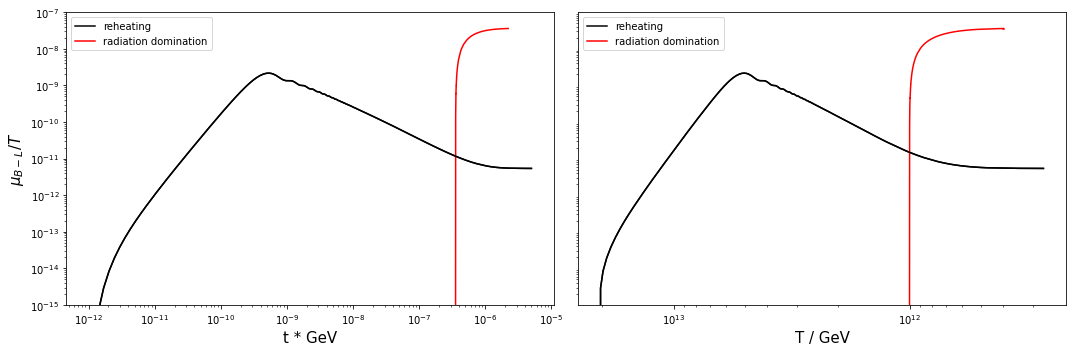

In [8]:
plot(ress, ress2, "rh_vs_raddom_bad_case.pdf")

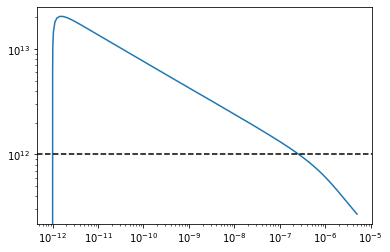

In [13]:
m_a = 1e6
Gamma_phi = cosmology.calc_inflaton_decay_rate_from_reheating_temperature(T_RH)

In [14]:
m = model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                     axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,), Gamma_phi, H_inf)
m2 = rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                     rad_dom_axion_motion.calc_d2Vdtheta2_simple, decay_rate, (m_a,))

In [15]:
%time ress_good = model.solve_to_end(m, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, collect=True, t_end=5e-5)
%time ress2_good = rad_dom_model.solve_to_end(m2, T_RH, (1, 0), calc_axion_mass=axion_motion.calc_const_axion_mass, T_end=4e11, collect=True)

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


done: SimulationState(initial=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), initial_reheating=(141.03361138137996, 141.03361138137996), t_start=1e-12, t_end=5e-05)
CPU times: user 1.02 s, sys: 3.99 ms, total: 1.02 s
Wall time: 1.02 s
CPU times: user 1.25 s, sys: 3 µs, total: 1.25 s
Wall time: 1.25 s


<ipython-input-6-dbcb5bbaa7d6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-6-dbcb5bbaa7d6>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
<ipython-input-6-dbcb5bbaa7d6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

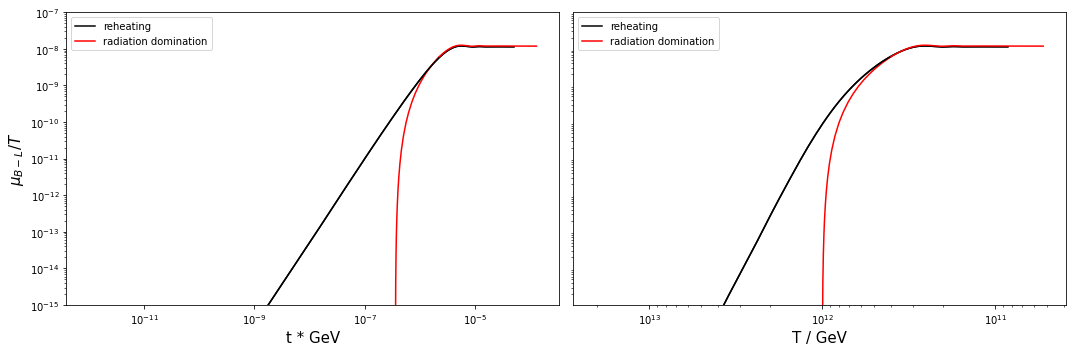

In [16]:
plot(ress_good, ress2_good, "rh_vs_raddom_good_case.pdf")

In [5]:
m_a_range = np.geomspace(1e6, 1e9, 21)
Gamma_phi_range = np.geomspace(1e6, 1e9, 20)
H_inf = 2e10
f_a = 3e14

In [6]:
%%time
def f(m_a, Gamma_phi):
    start_time = time.time()
    print(f"starting m_a = {m_a:.2e}, Gamma_phi = {Gamma_phi:.2e}", end="")
    ans = model.solve(model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, axion_motion.axion_rhs_simple, 
                                                           axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,), Gamma_phi, H_inf),
                              (1,0), f_a, calc_axion_mass=axion_motion.calc_const_axion_mass)
    end_time = time.time()
    print(" done in", end_time - start_time, "seconds")
    return ans
eta_B_rh = [[f(m_a, Gamma_phi) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

starting m_a = 1.00e+06, Gamma_phi = 1.00e+06

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/axion_decay.py:12: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


 done in 3.4117987155914307 seconds
starting m_a = 1.41e+06, Gamma_phi = 1.00e+06 done in 3.323474168777466 seconds
starting m_a = 2.00e+06, Gamma_phi = 1.00e+06 done in 3.3110203742980957 seconds
starting m_a = 2.82e+06, Gamma_phi = 1.00e+06 done in 3.242393970489502 seconds
starting m_a = 3.98e+06, Gamma_phi = 1.00e+06 done in 3.0702271461486816 seconds
starting m_a = 5.62e+06, Gamma_phi = 1.00e+06 done in 3.0262274742126465 seconds
starting m_a = 7.94e+06, Gamma_phi = 1.00e+06 done in 3.0296664237976074 seconds
starting m_a = 1.12e+07, Gamma_phi = 1.00e+06 done in 2.9757277965545654 seconds
starting m_a = 1.58e+07, Gamma_phi = 1.00e+06 done in 2.9630401134490967 seconds
starting m_a = 2.24e+07, Gamma_phi = 1.00e+06 done in 4.263640880584717 seconds
starting m_a = 3.16e+07, Gamma_phi = 1.00e+06 done in 4.145630598068237 seconds
starting m_a = 4.47e+07, Gamma_phi = 1.00e+06 done in 5.448898792266846 seconds
starting m_a = 6.31e+07, Gamma_phi = 1.00e+06 done in 5.38586688041687 seconds

In [7]:
%%time
eta_B_rad_dom = [[rad_dom_model.solve(rad_dom_model.AxionBaryogenesisModel(transport_equation.source_vector_weak_sphaleron, rad_dom_axion_motion.axion_rhs_simple, 
                                                                      rad_dom_axion_motion.calc_d2Vdtheta2_simple, calc_Gamma_a_SU2(m_a, f_a), (m_a,)), 
                                 cosmology.calc_reheating_temperature(Gamma_phi), (1,0), f_a, calc_axion_mass=rad_dom_axion_motion.calc_const_axion_mass)
                for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

../transport_eq/axion_decay.py:9: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
../transport_eq/axion_decay.py:12: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


CPU times: user 14min 52s, sys: 420 ms, total: 14min 53s
Wall time: 14min 53s


In [12]:
%%time
eta_B_original = [[original_model.compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_range] for Gamma_phi in Gamma_phi_range]

../axion_leptogenesis/model.py:193: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
../axion_leptogenesis/model.py:197: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
../axion_leptogenesis/model.py:193: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
../axion_leptogenesis/model.py:197: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
../axion_leptogenesis/model.py:197: RuntimeWarning: overflow encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
../axion_leptogenesis/model.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


CPU times: user 45.9 s, sys: 12 ms, total: 45.9 s
Wall time: 45.9 s


In [15]:
fname = "background_cosmology_comparison.pkl"
#util.save_data(fname, m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh)
#m_a_range, Gamma_phi_range, H_inf, f_a, eta_B_original, eta_B_rad_dom, eta_B_rh = util.load_data(fname)

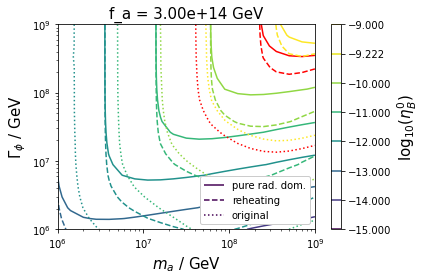

In [14]:
levels = np.hstack([np.arange(np.floor(np.log10(min(np.min(eta_B_rad_dom), np.min(eta_B_rh)))), 
          np.ceil(np.log10(max(np.max(eta_B_rad_dom), np.max(eta_B_rh)))),
          1), np.log10(constants.eta_B_observed)])
levels.sort()

CS = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rad_dom), levels)
plt.colorbar().set_label(r"$\log_{10} (\eta_B^0)$", fontsize=15)
CS.collections[np.where(CS.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS2 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_rh), levels, linestyles="--")
CS2.collections[np.where(CS2.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

CS3 = plt.contour(m_a_range, Gamma_phi_range, np.log10(eta_B_original), levels, linestyles=":")
CS3.collections[np.where(CS3.levels == np.log10(constants.eta_B_observed))[0][0]].set_color("red")

plt.title(f"f_a = {f_a:.2e} GeV", fontsize=15)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$m_a$ / GeV", fontsize=15)
plt.ylabel(r"$\Gamma_\phi$ / GeV", fontsize=15)
h1, _ = CS.legend_elements()
h2, _ = CS2.legend_elements()
h3, _ = CS3.legend_elements()
plt.legend([h1[0], h2[0], h3[0]], ["pure rad. dom.", "reheating", "original"], framealpha=1.0, loc=4)
plt.tight_layout()
plt.savefig(util.make_plot_path("rad_dom_vs_rh_parameter_space.pdf"))

In [19]:
t_start, init = reheating.calc_initial_reheating(H_inf)
t_end = 1e3*cosmology.switch_hubble_and_time_rad_dom(
    cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(cosmology.calc_reheating_temperature(Gamma_phi))))
T_fn, H_fn, T_dot_fn, _ = reheating.solve_reheating_eq(t_start, t_end, init, Gamma_phi)
ts = np.geomspace(t_start, t_end, 300)

In [22]:
def axion_jac(t, y):
    theta, theta_dot = y
    H = H_fn(t)
    T = T_fn(t)
    return np.array([
        [0,                                                     -1],
        [- axion_motion.calc_d2Vdtheta2_simple(T, theta, m_a), -3*H]
    ])

In [25]:
from numba import njit

In [27]:
type(T_fn)

function

In [45]:
%%time

m_a = 1e10

def rhs(log_t, y):
    theta, v = y
    t = np.exp(log_t)
    T = T_fn(t)
    H = H_fn(t)
    return (
        v * t,
        (- 3 * H_fn(t) * v - m_a**2 * theta) * t
    ) 

sol = solve_ivp(rhs, (np.log(t_start), np.log(5e-6)), (1, 0), dense_output=True, rtol=1e-3)

CPU times: user 51 s, sys: 95.6 ms, total: 51.1 s
Wall time: 51.1 s


In [ ]:
plt.l

In [42]:
theta = sol.sol(sol.t)[0]

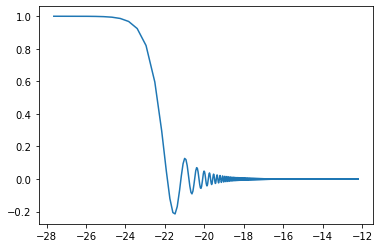

In [44]:
plt.plot(sol.t, theta)

In [41]:
theta_dot = sol.sol(sol.t)[1]
c = theta + theta_dot/m_a*1j
a = np.angle(c)
r = np.abs(c)

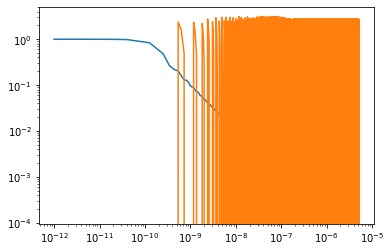

In [43]:
plt.loglog(sol.t, r)
plt.loglog(sol.t, a)

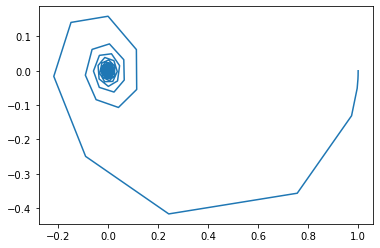

In [45]:
plt.plot(theta, theta_dot/m_a)